In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import os
import numpy as np
from sklearn import datasets, linear_model
import datetime
import time
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings(action='ignore')
Working_dir = os.getcwd()

In [26]:
zabbix_df = pd.read_excel( os.path.join( Working_dir, "zabbix_v2_py.xlsx" ) )
lsf_df = pd.read_excel( os.path.join( Working_dir, "lsf_v2_py.xlsx" ) )
# zabbix_month_df = pd.read_excel( os.path.join( Working_dir, "zabbix_month_py.xlsx" ) )
# lsf_month_df = pd.read_excel( os.path.join( Working_dir, "lsf_month_py.xlsx" ) )

### Extract data for 19, February, 2017, 12:00 - 19, March, 2017, 12:00 and so on each month

In [ ]:
print('The earliest timestamp in each table')
print(zabbix_df.timestamp_py.min(), '\n',datetime.datetime.utcfromtimestamp(lsf_df['start unixtime'].min()),'\n') 

print('The latest timestamp in each table')
print(zabbix_df.timestamp_py.max(), '\n',datetime.datetime.utcfromtimestamp(lsf_df['stop unixtime'].max())) 

In [ ]:
def lsf_one_month( lsf_df, zabbix_df, start_moment, end_moment, folder_name ):
    lsf_month_df = pd.DataFrame(columns = lsf_df.columns.values)
    
    lsf_month_df = lsf_df[((lsf_df.start_timestamp_py >= start_moment)   & (lsf_df.stop_timestamp_py <= end_moment) \
       | (lsf_df.start_timestamp_py <= start_moment) & (lsf_df.stop_timestamp_py >= start_moment) \
       | (lsf_df.start_timestamp_py <= end_moment  ) & (lsf_df.stop_timestamp_py  >= end_moment) \
       | (lsf_df.start_timestamp_py <= start_moment) & (lsf_df.stop_timestamp_py  >= end_moment))].copy()
        
    excel_writer_lsf_month = pd.ExcelWriter( os.path.join( folder_name, 'lsf_month_py.xlsx') )
    lsf_month_df.to_excel(excel_writer_lsf_month)
    excel_writer_lsf_month.save()
    
    return lsf_month_df

In [ ]:
def zabbix_one_month( lsf_df, zabbix_df, start_datetime, end_datetime, folder_name ):

    zabbix_month_df = pd.DataFrame(columns = zabbix_df.columns.values)
    
    zabbix_month_df = zabbix_df[((zabbix_df.timestamp_py >= start_datetime) & \
                                 (zabbix_df.timestamp_py < end_datetime))].copy()
    
    return zabbix_month_df

In [ ]:
def process_matrix_one_month ( zabbix_month_df, lsf_month_df, folder_name ):
    proc_df = pd.DataFrame(columns = lsf_month_df.executable_full_name.unique(), index=zabbix_month_df.timestamp_py)

    min_time = zabbix_month_df.timestamp_py.iloc[0]
    max_time = zabbix_month_df.timestamp_py.iloc[zabbix_month_df.shape[0]-1] + datetime.timedelta(minutes = 59, seconds = 59)
    max_cores = lsf_month_df['number of cores used'].max()

    proc_df[:] = 0 
    i=0
    # iterate over jobs in lsf
    for index, line in lsf_month_df.iterrows():#.iloc[]
    #     print(line)
        #i-line index
        i+=1
        job_name = line.executable_full_name
        cores = line['number of cores used']
        # start and end time in full date format 
        start_time = line.start_timestamp_py
#         datetime.datetime.combine(line.start_date_py, \
#                                                line.start_time_py )
        end_time = line.stop_timestamp_py
#     datetime.datetime.combine(line.end_date_py, \
#                                                line.end_time_py )
        # t is our current position
        t = start_time
        # process length
        length = end_time - start_time + datetime.timedelta(seconds=1)
        # if a proces began before the first timestamp in zabbix
        # decrease length and step onto the first timestamp in zabbix
        if min_time > start_time:
            t = min_time
            length -= min_time - start_time
        # while current position is not at the end time of a process or end of table
        while t <= end_time and t <= max_time:
            # find row name in table = even hour and next row name
            start_in_table = t
            start_in_table = start_in_table.replace(minute=0, second=0)
            next_in_table = start_in_table + datetime.timedelta(hours=1)

            # if a process ends within this hour write its weight 
            # and put current position far to the right
            if ( t + length < next_in_table ):
    #             print('length', length)
                proc_df.loc[start_in_table,job_name] += (length.total_seconds()/3600)*(cores)#/max_cores)
                t = next_in_table
            else:
                # if a process lasts longer than the current hour range
                # add number of seconds which it runs during this hour
                # decrease length of the process by the same mount
                # write its weight to the matrix
                to_add = next_in_table - t
                length -= to_add

                proc_df.loc[start_in_table,job_name] += (to_add.total_seconds()/3600)*(cores)#/max_cores)
                t += to_add
        if (i % 1000 == 0):
            print(i)
    excel_writer_matrix = pd.ExcelWriter( os.path.join( folder_name, 'proc_matrix_month.xlsx') )
    proc_df.to_excel(excel_writer_matrix)
    excel_writer_matrix.save()
    return proc_df

In [ ]:
def divide ( a, b ):
    c = np.zeros_like(a)
    for i in range(len(a)):
        if ( 0 != b[i] ):
            c[i] = a[i]/b[i]
        else:
            c[i] = None
    return c

In [ ]:
def outliers_to_zero(x):
    final_list = x.copy()
    outliers_indices = x[(x - x.median()) > 2 * (x.quantile(.75)-x.quantile(0.25))].index
#     print(final_list.loc[outliers_indices])
    final_list.loc[outliers_indices] = 0
    return final_list, outliers_indices

------
### Main procedure

In [ ]:
lsf_df_in_case = lsf_df.copy()

In [ ]:
# lsf_df=lsf_df_in_case.copy()

In [ ]:
x = []
zero_sum = pd.DataFrame(columns = zabbix_df.columns.values)

In [ ]:
left_time_border = datetime.datetime(2017,2,19,12,0)
right_time_border = datetime.datetime(2017,3,19,12,0)

# left_time_border = datetime.datetime(2017,12,19,12,0)
# right_time_border = datetime.datetime(2017,12,19,12,0)

# date_new = lsf_df.stop_timestamp_py.max().date()
# right_time_border = datetime.datetime.combine(date_new, right_time_border.time())

m = 1
while ( right_time_border <= \
       datetime.datetime.combine(lsf_df.stop_timestamp_py.max().date(), \
                                 right_time_border.time())):
    
    folder_name = Working_dir + "\\"\
              + left_time_border.strftime("%d.%m.%Y %H.%M") \
              + right_time_border.strftime(" - %d.%m.%Y %H.%M")
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)
        
    # decrease lsf_df
    lsf_df = lsf_df.drop(lsf_df[lsf_df.stop_timestamp_py < left_time_border].index )
        
    lsf_month_df = lsf_one_month( lsf_df, zabbix_df, left_time_border, right_time_border, folder_name )
    zabbix_month_df = zabbix_one_month ( lsf_df, zabbix_df, left_time_border, right_time_border, folder_name )
    proc_df = process_matrix_one_month ( zabbix_month_df, lsf_month_df, folder_name )
    
    f = zabbix_month_df['energy_avg (kWh)'].as_matrix()*1000
    sum_coeff_avg = proc_df.as_matrix().sum(axis=1)
    
    zero_ix = np.where(sum_coeff_avg==0)
    zero_sum = zero_sum.append(zabbix_month_df.iloc[zero_ix])
    
#     sum_coeff_avg = np.delete(sum_coeff_avg, zero_ix)
#     f = np.delete(f, zero_ix)
#     x_avg = np.zeros(zabbix_month_df.shape[0])
    x_avg = divide (f, sum_coeff_avg)
    
    zabbix_month_df['estimated_en_use'] = x_avg
    
    if (np.nanmax(x_avg)/np.nanmin(x_avg) > 1000):
        x_avg_no_outliers, outliers_ix = outliers_to_zero(zabbix_month_df['estimated_en_use'])
        zabbix_month_df['estimated_en_use_no_outliers'] = x_avg_no_outliers
        zabbix_month_df['estimated_en_use_of_outliers'] = zabbix_month_df.loc[outliers_ix, \
                                                                              'estimated_en_use']
    else:
        zabbix_month_df['estimated_en_use_no_outliers'] = x_avg_no_outliers
        zabbix_month_df['estimated_en_use_of_outliers'] = None
        
    excel_writer_zabbix_month = pd.ExcelWriter(os.path.join( folder_name, 'zabbix_month_py.xlsx'))
    zabbix_month_df.to_excel(excel_writer_zabbix_month)
    excel_writer_zabbix_month.save()
       
#     f = open( os.path.join( folder_name, "avg_power_app_per_core_per_sec.txt") ,"w+" )
#     for item in x_avg:
#         f.write(str(item) + '\n')
#     f.close()
          
    left_time_border = right_time_border
    
    if (12 > right_time_border.month):
        date_new = datetime.date(year=right_time_border.year, month=right_time_border.month+1, day=right_time_border.day)
    else:
        date_new = lsf_df.stop_timestamp_py.max().date()
    right_time_border = datetime.datetime.combine(date_new, right_time_border.time())
    
    x.append(np.mean(x_avg))
    print(m)
    m+=1
    if m==2:
        break

In [ ]:
zero_ix

In [ ]:
start = zabbix_month_df.timestamp_py.iloc[17]
end = start + datetime.timedelta(hours=1)

In [ ]:
lsf_df_in_case[((lsf_df_in_case.start_timestamp_py >= start)   & (lsf_df_in_case.stop_timestamp_py <= end) \
       | (lsf_df_in_case.start_timestamp_py <= start) & (lsf_df_in_case.stop_timestamp_py >= start) \
       | (lsf_df_in_case.start_timestamp_py <= end  ) & (lsf_df_in_case.stop_timestamp_py  >= end) \
       | (lsf_df_in_case.start_timestamp_py <= start) & (lsf_df_in_case.stop_timestamp_py  >= end))]

In [ ]:
zero_sum_copy = zero_sum.copy()

In [ ]:
zero_sum

In [ ]:
x

In [ ]:
excel_writer_zero_sum = pd.ExcelWriter( os.path.join( Working_dir, 'zero_sum.xlsx') )
zero_sum.to_excel(excel_writer_zero_sum)
excel_writer_zero_sum.save()

In [ ]:
f = open( os.path.join( Working_dir, "x.txt") ,"w+" )
for item in x:
    f.write(str(item) + '\n')
f.close()

----
### Estimation on energy use in idle mode
1) Max and min registered energy use


In [4]:
zero_sum = pd.read_excel( os.path.join( Working_dir, "zero_sum.xlsx" ) )

In [5]:
print(zabbix_df['energy_avg (kWh)'].max(), zabbix_df['energy_avg (kWh)'].min())

65.516 14.383625



2) Max, min and avg energy use when no process is registered to be active

In [6]:
print(zero_sum['energy_avg (kWh)'].max(), \
      zero_sum['energy_avg (kWh)'].min(), \
      zero_sum['energy_avg (kWh)'].mean())

58.126 31.84 42.20452433035714


3) Avg energy use during hours when there were active processes ongoing

In [7]:
zabbix_df.drop(zero_sum.index)['energy_avg (kWh)'].mean()

47.02398681951323

### Conclusion on idle mode energy use: missing data in the lsf dataset.
Reason: average energy consumption during the hours with active processes running is 47 kWh, while it equals 42 kWh when no processes are registered to be active.

Moreover, the range of energy consumed when no processes are active lies within the range of energy consumption when cores are calculating the jobs. 


In [8]:
print('"Idle mode" energy range: [',\
      zero_sum['energy_avg (kWh)'].min(),',\t',\
      zero_sum['energy_avg (kWh)'].max(),\
     ']\nOveral energy use range: [',\
      zabbix_df['energy_avg (kWh)'].min(),',\t',\
      zabbix_df['energy_avg (kWh)'].max(), ']')

"Idle mode" energy range: [ 31.84 ,	 58.126 ]
Overal energy use range: [ 14.383625 ,	 65.516 ]


-----
### Delete outliers in the solution

In [ ]:
left_time_border = datetime.datetime(2017,12,19,12,0)
# right_time_border = datetime.datetime(2017,12,19,12,0)

date_new = lsf_df.stop_timestamp_py.max().date()
right_time_border = datetime.datetime.combine(date_new, right_time_border.time())

m = 1
    
folder_name = Working_dir + "\\"\
          + left_time_border.strftime("%d.%m.%Y %H.%M") \
          + right_time_border.strftime(" - %d.%m.%Y %H.%M")

zabbix_month_df = pd.read_excel( os.path.join( folder_name, "zabbix_month_py.xlsx" ) )
lsf_month_df = pd.read_excel( os.path.join( folder_name, "lsf_month_py.xlsx" ) )
proc_df = pd.read_excel( os.path.join( folder_name, "proc_matrix_month.xlsx" ) )
proc_df.index=proc_df.iloc[:,0]
proc_df.drop('timestamp_py', axis=1, inplace=True)

f = zabbix_month_df['energy_avg (kWh)'].as_matrix()*1000
sum_coeff_avg = proc_df.as_matrix().sum(axis=1)

zero_ix = np.where(sum_coeff_avg==0)

x_avg = divide (f, sum_coeff_avg)

zabbix_month_df['estimated_en_use'] = x_avg

if (np.nanmax(x_avg)/np.nanmin(x_avg) > 1000):
    x_avg_no_outliers, outliers_ix = outliers_to_zero(zabbix_month_df['estimated_en_use'])
    zabbix_month_df['estimated_en_use_no_outliers'] = x_avg_no_outliers
    zabbix_month_df['estimated_en_use_of_outliers'] = zabbix_month_df.loc[outliers_ix, \
                                                                          'estimated_en_use']
else:
    zabbix_month_df['estimated_en_use_no_outliers'] = x_avg
    zabbix_month_df['estimated_en_use_of_outliers'] = None

excel_writer_zabbix_month = pd.ExcelWriter(os.path.join( folder_name, 'zabbix_month_py.xlsx'))
zabbix_month_df.to_excel(excel_writer_zabbix_month)
excel_writer_zabbix_month.save()

m+=1
print(m)

---
### Calculating the energy wasted for exited jobs

In [ ]:
# exited_en_cons = []

In [32]:
summary = pd.DataFrame(columns=['month_start', 'month_end', 'en_exit_jobs', \
                                'en_done_jobs','en_no_outliers','en_with_outliers'], index=range(0,13))
summary[:]=0

In [102]:
i = 10
left_time_border = datetime.datetime(2017,i+2,19,12,0)
# right_time_border = datetime.datetime(2017,i+3,19,12,0)
i=i+1
date_new = lsf_df.stop_timestamp_py.max().date()
right_time_border = datetime.datetime.combine(date_new, right_time_border.time())

m = 1
    
folder_name = Working_dir + "\\"\
          + left_time_border.strftime("%d.%m.%Y %H.%M") \
          + right_time_border.strftime(" - %d.%m.%Y %H.%M")

zabbix_month_df = pd.read_excel( os.path.join( folder_name, "zabbix_month_py.xlsx" ) )
lsf_month_df = pd.read_excel( os.path.join( folder_name, "lsf_month_py.xlsx" ) )
proc_df = pd.read_excel( os.path.join( folder_name, "proc_matrix_month.xlsx" ) )
proc_df.index=proc_df.iloc[:,0]
proc_df.drop('timestamp_py', axis=1, inplace=True)

energy_matrix_exit_month = proc_df.copy()
energy_matrix_exit_month[:] = 0

# proc_mult = pd.DataFrame(columns = proc_df.columns.values, index=proc_df.index)
# proc_mult[:] = 0


lsf_exited_month_df = lsf_month_df[lsf_month_df['job status'].str.lower() == \
                                   "exit"][["executable_full_name", \
                                            "start_timestamp_py",  \
                                            "stop_timestamp_py"]]
# lsf_exited_month_df["energy_consumed_kwh"] = 0

for index, lsf_current_line in (lsf_exited_month_df.iterrows()):
#     i+=1
    name = lsf_current_line.executable_full_name
#     print(lsf_current_line,'\n')
    lsf_df_start_time = lsf_current_line.start_timestamp_py
    lsf_df_stop_time = lsf_current_line.stop_timestamp_py
    
    zabbix_start_time = datetime.datetime.combine( lsf_df_start_time.date(), \
                                                   datetime.time(hour=lsf_df_start_time.time().hour, \
                                                                minute=0, second=0) )
    zabbix_stop_time = datetime.datetime.combine( lsf_df_stop_time.date(), \
                                                  datetime.time(hour=lsf_df_stop_time.time().hour, \
                                                                minute=0, second=0) )
    
    zabbix_first_line = zabbix_month_df.timestamp_py.iloc[0]
    zabbix_last_line = zabbix_month_df.timestamp_py.iloc[zabbix_month_df.shape[0]-1]
    
    if ( zabbix_start_time < zabbix_first_line):
        zabbix_start_time = zabbix_first_line
    if ( zabbix_stop_time > zabbix_last_line):
        zabbix_stop_time = zabbix_last_line
    
    energy_matrix_exit_month.loc[zabbix_start_time:zabbix_stop_time, \
                                 lsf_current_line.executable_full_name] = \
    proc_df.loc[zabbix_start_time:zabbix_stop_time, \
                lsf_current_line.executable_full_name]
    

    
z = zabbix_month_df.estimated_en_use_no_outliers.fillna(0).as_matrix()
energy_matrix_done_month = proc_df.copy()

for name in proc_df.columns.values:
    energy_matrix_done_month.loc[:,name] = proc_df.loc[:, name].as_matrix()*z/1000.
    if name in list(lsf_exited_month_df.executable_full_name):
        energy_matrix_exit_month.loc[:,name] = energy_matrix_exit_month.loc[:, name].as_matrix()*z/1000.
energy_matrix_done_month = energy_matrix_done_month - energy_matrix_exit_month        
        
summary.loc[i,'month_start'] = left_time_border
summary.loc[i,'month_end'] = right_time_border

summary.loc[i,'en_exit_jobs'] = energy_matrix_exit_month.as_matrix().sum(axis=0).sum()
summary.loc[i,'en_done_jobs']= energy_matrix_done_month.as_matrix().sum(axis=0).sum()
summary.loc[i,'en_no_outliers'] = summary.loc[i,'en_exit_jobs'] + summary.loc[i,'en_done_jobs']
summary.loc[i,'en_with_outliers'] = zabbix_month_df['energy_avg (kWh)'].sum()
# print(summary.en_exit_jobs[i])

job_exit_energy = energy_matrix_exit_month[lsf_exited_month_df.executable_full_name.unique()].sum(axis=0)
job_done_energy = energy_matrix_done_month[lsf_month_df[lsf_month_df['job status'].str.lower() == \
                                   "done"]["executable_full_name"].unique()].sum(axis=0)

zabbix_month_df['energy_for_exited_jobs_kwh'] = energy_matrix_exit_month.as_matrix().sum(axis=1)*\
    zabbix_month_df.estimated_en_use_no_outliers.as_matrix()/1000

    
excel_writer_zabbix_month = pd.ExcelWriter(os.path.join( folder_name, 'zabbix_month_py.xlsx'))
zabbix_month_df.to_excel(excel_writer_zabbix_month)
excel_writer_zabbix_month.save()

excel_writer_en_exit = pd.ExcelWriter(os.path.join( folder_name, 'en_matrix_exit.xlsx'))
energy_matrix_exit_month.to_excel(excel_writer_en_exit)
excel_writer_en_exit.save()

excel_writer_en_done = pd.ExcelWriter(os.path.join( folder_name, 'en_matrix_done.xlsx'))
energy_matrix_done_month.to_excel(excel_writer_en_done)
excel_writer_en_done.save()

excel_writer_en_done_every_job = pd.ExcelWriter(os.path.join( folder_name, 'en_matrix_done_every_job.xlsx'))
job_done_energy.to_excel(excel_writer_en_done_every_job)
excel_writer_en_done_every_job.save()

excel_writer_en_exit_every_job = pd.ExcelWriter(os.path.join( folder_name, 'en_matrix_exit_every_job.xlsx'))
job_exit_energy.to_excel(excel_writer_en_exit_every_job)
excel_writer_en_exit_every_job.save()

In [105]:
excel_writer_summary = pd.ExcelWriter(os.path.join( Working_dir, 'energy_summary.xlsx'))
summary.to_excel(excel_writer_summary)
excel_writer_summary.save()

In [103]:
summary

,month_start,month_end,en_exit_jobs,en_done_jobs,en_no_outliers,en_with_outliers
1,2017-02-19 12:00:00,2017-03-19 12:00:00,14708,16432.7,31140.8,31140.8
2,2017-03-19 12:00:00,2017-04-19 12:00:00,19971.5,15668.1,35639.6,35675.4
3,2017-04-19 12:00:00,2017-05-19 12:00:00,8232.71,21627.8,29860.5,33283.8
4,2017-05-19 12:00:00,2017-06-19 12:00:00,11334.9,18379,29713.9,33873.5
5,2017-06-19 12:00:00,2017-07-19 12:00:00,12490.6,20528.9,33019.5,33019.5
6,2017-07-19 12:00:00,2017-08-19 12:00:00,4305.68,22078.2,26383.8,31069.2
7,2017-08-19 12:00:00,2017-09-19 12:00:00,7474.38,18739.4,26213.8,28867.4
8,2017-09-19 12:00:00,2017-10-19 12:00:00,22109.2,9473.77,31583,34958.7
9,2017-10-19 12:00:00,2017-11-19 12:00:00,23341.9,9341.03,32683,37476.9
10,2017-11-19 12:00:00,2017-12-19 12:00:00,31306.8,7185.7,38492.5,38492.5


----
### Analysing results

In [2]:
summary = pd.read_excel( os.path.join( Working_dir, "energy_summary.xlsx" ) )

In [7]:
14708.040092 + 16432.724325

31140.764417

In [10]:
summary

,month_start,month_end,en_exit_jobs,en_done_jobs,en_no_outliers,en_with_outliers
1,2017-02-19 12:00:00,2017-03-19 12:00:00,14708.040092,16432.724325,31140.764417,31140.764417
2,2017-03-19 12:00:00,2017-04-19 12:00:00,19971.451032,15668.141326,35639.592358,35675.376358
3,2017-04-19 12:00:00,2017-05-19 12:00:00,8232.712321,21627.799100,29860.511421,33283.833554
4,2017-05-19 12:00:00,2017-06-19 12:00:00,11334.915364,18379.033057,29713.948421,33873.466033
5,2017-06-19 12:00:00,2017-07-19 12:00:00,12490.617675,20528.884200,33019.501875,33019.501875
6,2017-07-19 12:00:00,2017-08-19 12:00:00,4305.677956,22078.165694,26383.843650,31069.230888
7,2017-08-19 12:00:00,2017-09-19 12:00:00,7474.381397,18739.436953,26213.818350,28867.394600
8,2017-09-19 12:00:00,2017-10-19 12:00:00,22109.201644,9473.771468,31582.973112,34958.687683
9,2017-10-19 12:00:00,2017-11-19 12:00:00,23341.919420,9341.034355,32682.953775,37476.907925
10,2017-11-19 12:00:00,2017-12-19 12:00:00,31306.806265,7185.704064,38492.510329,38492.510329


In [14]:
summary[['en_exit_jobs','en_done_jobs']]/1000

,en_exit_jobs,en_done_jobs
1,14.708040,16.432724
2,19.971451,15.668141
3,8.232712,21.627799
4,11.334915,18.379033
5,12.490618,20.528884
6,4.305678,22.078166
7,7.474381,18.739437
8,22.109202,9.473771
9,23.341919,9.341034
10,31.306806,7.185704


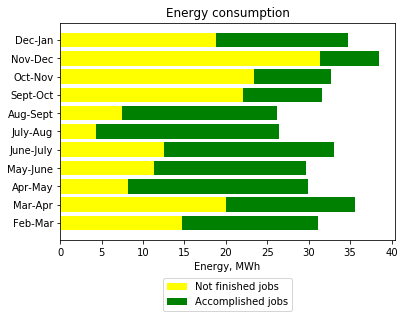

In [57]:
s=summary[['en_exit_jobs','en_done_jobs']].copy()
s = s/1000
s1 = s.copy()
s1.en_done_jobs = s1.en_done_jobs/(s.en_done_jobs+s.en_exit_jobs)*100
s1.en_exit_jobs = s1.en_exit_jobs/(s.en_done_jobs+s.en_exit_jobs)*100

fig, ax = plt.subplots()

N = 11
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.barh(ind, s.en_exit_jobs, color='yellow')

p2 = plt.barh( ind, s.en_done_jobs, color='green', left = s.en_exit_jobs )

plt.xlabel('Energy, MWh')
plt.title('Energy consumption')
# plt.xticks(ind, ('Feb-\nMar', 'Mar-\nApr', 'Apr-\nMay', 'May-\nJune', 'June-\nJuly',\
#                 'July-\nAug', 'Aug-\nSept', 'Sept-\nOct','Oct-\nNov', 'Nov-\nDec',\
#                 'Dec-\nJan'))

# max_en = s.en_done_jobs+s.en_exit_jobs
# max_en -= max_en % -100
# max_en = int(max_en)

# plt.xticks(ind, ('Feb-\nMar', 'Mar-\nApr', 'Apr-\nMay', 'May-\nJune', 'June-\nJuly',\
#                 'July-\nAug', 'Aug-\nSept', 'Sept-\nOct','Oct-\nNov', 'Nov-\nDec',\
#                 'Dec-\nJan'))
plt.yticks(ind, ('Feb-Mar', 'Mar-Apr', 'Apr-May', 'May-June', 'June-July',\
                'July-Aug', 'Aug-Sept', 'Sept-Oct','Oct-Nov', 'Nov-Dec',\
                'Dec-Jan'))
lgd = plt.legend((p1[0], p2[0]), ('Not finished jobs', 'Accomplished jobs'),\
           loc='upper center', bbox_to_anchor=(0.5, -0.15))
fig.savefig(os.path.join(Working_dir, 'energy_cons_ex_done.png'),bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

---
### Jobs ditribution by energy consumption

In [27]:
# lsf_df.stop_timestamp_py.max()
# Timestamp('2018-01-25 04:12:17')

Timestamp('2018-01-25 04:12:17')

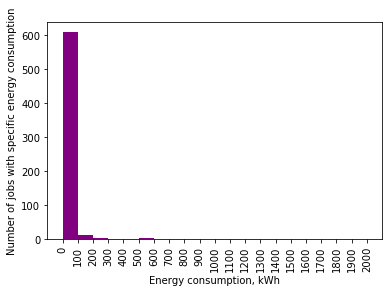

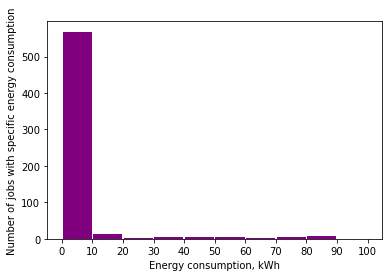

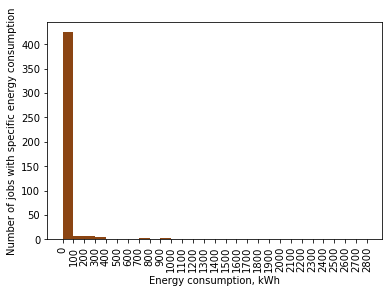

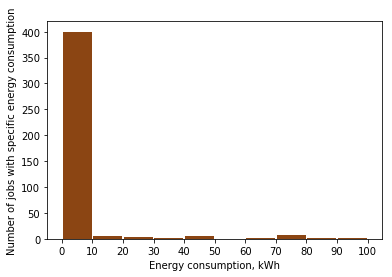

In [51]:
i = 0
left_time_border = datetime.datetime(2017,i+2,19,12,0)
right_time_border = datetime.datetime(2017,i+3,19,12,0)
i=i+1
# date_new = lsf_df.stop_timestamp_py.max().date()
# right_time_border = datetime.datetime.combine(date_new, right_time_border.time())

m = 1
    
folder_name = Working_dir + "\\"\
          + left_time_border.strftime("%d.%m.%Y %H.%M") \
          + right_time_border.strftime(" - %d.%m.%Y %H.%M")

job_done_energy = pd.read_excel(os.path.join( folder_name, 'en_matrix_done_every_job.xlsx'))
job_exit_energy = pd.read_excel(os.path.join( folder_name, 'en_matrix_exit_every_job.xlsx'))

max_en = job_done_energy[0].values.max()
max_en -= max_en % -100
max_en = int(max_en)
bins = np.array(range(0,max_en,100))
groups = job_done_energy[0].groupby(pd.cut(job_done_energy[0],bins))

pos = (range(len(bins)-1))


plt.bar(pos, groups.size(), color='purple', width = 1)
plt.xlabel('Energy consumption, kWh')
plt.ylabel('Number of jobs with specific energy consumption')
plt.xticks(np.append(np.array(pos), len(bins)-1)-0.5, bins.astype(int), rotation=90)

plt.savefig(os.path.join(folder_name, 'en_cons_done.png'), bbox_inches='tight')
plt.show()

max_en = 110
bins = np.array(range(0,max_en,10))
groups = job_done_energy[0].groupby(pd.cut(job_done_energy[0],bins))

pos = (range(len(bins)-1))


plt.bar(pos, groups.size(), color='purple', width = 0.95)
plt.xlabel('Energy consumption, kWh')
plt.ylabel('Number of jobs with specific energy consumption')
plt.xticks(np.append(np.array(pos), len(bins)-1)-0.5, bins.astype(int))

plt.savefig(os.path.join(folder_name, 'en_cons_done_granular.png'), bbox_inches='tight')
plt.show()




max_en = job_exit_energy[0].values.max()
max_en -= max_en % -100
max_en = int(max_en)
bins = np.array(range(0,max_en,100))
groups = job_exit_energy[0].groupby(pd.cut(job_exit_energy[0],bins))

pos = (range(len(bins)-1))


plt.bar(pos, groups.size(), color='saddlebrown', width = 1)
plt.xlabel('Energy consumption, kWh')
plt.ylabel('Number of jobs with specific energy consumption')
plt.xticks(np.append(np.array(pos), len(bins)-1)-0.5, bins.astype(int), rotation=90)

plt.savefig(os.path.join(folder_name, 'en_cons_exit.png'), bbox_inches='tight')
plt.show()

max_en = 110
bins = np.array(range(0,max_en,10))
groups = job_exit_energy[0].groupby(pd.cut(job_exit_energy[0],bins))

pos = (range(len(bins)-1))


plt.bar(pos, groups.size(), color='saddlebrown', width = 0.95)
plt.xlabel('Energy consumption, kWh')
plt.ylabel('Number of jobs with specific energy consumption')
plt.xticks(np.append(np.array(pos), len(bins)-1)-0.5, bins.astype(int))

plt.savefig(os.path.join(folder_name, 'en_cons_exit_granular.png'), bbox_inches='tight')
plt.show()

----
### Percent of jobs consuming less than 10 kWh for each month

In [45]:
right_limit = datetime.datetime(year=2018, month=1, day=25, hour = 12)

In [46]:
percent = []

left_time_border = datetime.datetime(2017,2,19,12,0)
right_time_border = datetime.datetime(2017,3,19,12,0)

# left_time_border = datetime.datetime(2017,12,19,12,0)
# right_time_border = datetime.datetime(2017,12,19,12,0)

# date_new = lsf_df.stop_timestamp_py.max().date()
# right_time_border = datetime.datetime.combine(date_new, right_time_border.time())

m = 1

while ( right_time_border <= right_limit ):
    
    folder_name = Working_dir + "\\"\
              + left_time_border.strftime("%d.%m.%Y %H.%M") \
              + right_time_border.strftime(" - %d.%m.%Y %H.%M")
            
    
    job_done_energy = pd.read_excel(os.path.join( folder_name, 'en_matrix_done_every_job.xlsx'))
    job_exit_energy = pd.read_excel(os.path.join( folder_name, 'en_matrix_exit_every_job.xlsx'))
    
    registered_jobs_num = job_done_energy.shape[0] + job_exit_energy.shape[0]
    p = job_done_energy[job_done_energy[0] <= 10].shape[0] + job_exit_energy[job_exit_energy[0] <= 10].shape[0] 
    p = p/registered_jobs_num * 100
    percent.append(p)

    left_time_border = right_time_border
    
    if (12 > right_time_border.month):
        date_new = datetime.date(year=right_time_border.year, month=right_time_border.month+1, day=right_time_border.day)
        right_time_border = datetime.datetime.combine(date_new, right_time_border.time())
    else:
        right_time_border = right_limit
    
    
    m+=1
#     if (m==2):
#         break
print(percent)

[88.83888388838884, 78.51851851851852, 65.39634146341463, 61.336032388663966, 57.2265625, 53.76344086021505, 56.72645739910314, 75.87209302325581, 73.6024844720497, 76.29032258064517, 64.9867374005305]


In [47]:
folder_name

'C:\\Users\\aagri\\Documents\\Python Scripts\\PERCCOM Energy Data\\Data v.2\\19.12.2017 12.00 - 25.01.2018 12.00'

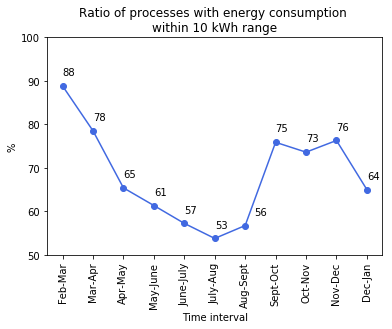

In [87]:
fig, ax = plt.subplots()

N = 11
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.plot(ind, percent, color='royalblue', linestyle='-', marker='o',)

plt.xlabel('Time interval')
plt.ylabel('%')

plt.title('Ratio of processes with energy consumption \nwithin 10 kWh range')

plt.xticks(ind, ('Feb-Mar', 'Mar-Apr', 'Apr-May', 'May-June', 'June-July',\
                'July-Aug', 'Aug-Sept', 'Sept-Oct','Oct-Nov', 'Nov-Dec',\
                'Dec-Jan'), rotation=90)
plt.yticks(range(50,110,10))

for i, j in zip(ind, percent):
    if (i==6):
        ax.annotate(str(int(j)), xy=(i+0.3, j+2), horizontalalignment='left',
            verticalalignment='bottom')
    else:
        ax.annotate(str(int(j)), xy=(i, j+2), horizontalalignment='left',
            verticalalignment='bottom')
#     plt.text(i, j, str((int(j))) )

fig.savefig(os.path.join(Working_dir, 'en_cons_less_10.png'),bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()